<a href="https://colab.research.google.com/github/HyunLee103/Audio_data_preprocessing/blob/master/CNN_Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [0]:
# only used in colab
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [0]:
print (tf.__version__)

2.2.0-rc2


In [0]:
JSON_PATH = "/content/drive/My Drive/Sound AI/data_10.json"

**데이터 load 함수**

In [0]:
def load_data(data_PATH):
  with open(data_PATH, "r") as fp:
    data = json.load(fp)
  
  X = np.array(data['mfcc']) # 4998개 음원에 대해서 259 x 13 MFCC feature
  y = np.array(data['labels']) # 각 음원의 장르 라벨 0 ~ 9

  return X,y

**학습 history 시각화 함수**

In [0]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

**train test split / CNN을 위해 인풋 3차원으로 변환**

In [0]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # 텐서 플로우에서 2D Conv는 3차원 인풋을 요한다. 우리 데이터는 각 오디오 샘플에 대한 259 x 13 feature
    # 이므로 뒤에 축을 추가해 259 x 13 x 1 로 만들어 주자
    # 1D Conv면 2차원 인풋 필요! 
    X_train = X_train[..., np.newaxis]  # X_train > (# of audio sample, 259, 13) 이므로 ... 세개 주고 np.newaxis로 새로운 축을 추가
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

 **Modeling**

In [0]:
def modeling(input): # 첫번째 layer의 input shape이 파라미터
  
  model = tf.keras.Sequential()

  # 2D Conv는 3x3 filter에 패딩 1, stride 1 주면 ouput shape이 동일해진다. keras 에서 default는 패딩 없음! stride = 1
  model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = input)) # 첫번째 layer에는 input_shape 지정해줘야한다!
  model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same')) # maxpooling은 2x2 stride 2 하면 shape이 절반으로 줄어든다(일반적인 pooling 기법 국룰)
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
  model.add(tf.keras.layers.BatchNormalization()) 

  model.add(tf.keras.layers.Conv2D(128,(2,2),activation='relu')) # Q : 여기 filter를 처음 (3,3)으로 줬는데 에러나고 (2,2)로 주니까 돌아가는데 왜그러지
                                                                 # A : 이전 layer output의 차원이 (None, 64, 2, 64) 이래서 3x3 filter 적용이 안됨
  model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
  model.add(tf.keras.layers.BatchNormalization()) 

  # flatten 시켜서 FC에 넣어서 최종 layer를 분류 수에 맞춰주자
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.6))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  return model

**Word CNN** 


---

sequential 데이터에 적용 가능한 CNN 모델, 텍스트에도 쓰지만 audio 데이터도 sequential 하므로 적용해보면 괜찮지 않을까? 결국 MFCC는 한 time step 단위로 의미를 가진다고 해석할 수 있으니까 말이다

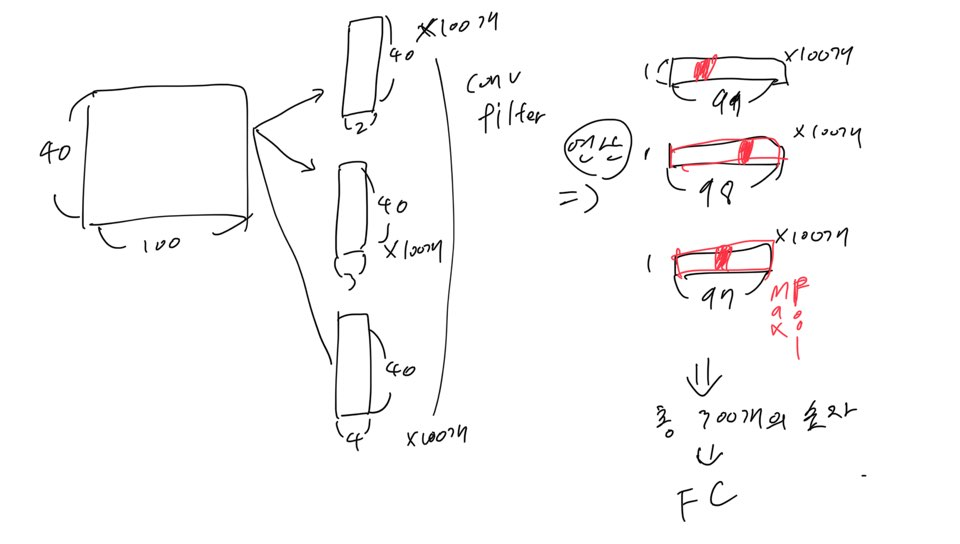

***

**Estimate**

In [0]:
def estimate(model,X,y):
  
  X = X[np.newaxis,...]
  prediction = model.predict(X)

  predicted_index = np.argmax(prediction, axis=1)

  print("Target : {}, predicted label : {}".format(y,predicted_index))

**main 함수**

In [0]:
if __name__ == '__main__':
 
  # data load
  X_train, X_valid, X_test,y_train,y_valid,y_test = prepare_datasets(0.25,0.2)
 
  # create model
  input = (X_train.shape[1],X_train.shape[2],X_train.shape[3]) # 259 x 13 x 1
  model = modeling(input)

  # complie model
  algorithm = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer= algorithm, 
                loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy는 integer 타입, 타겟을 원핫인코딩 안해도 된다 
                metrics=['accuracy'] )                  # categorical_crossentropy는 bool 타입, 타겟을 원핫인코딩 해줘야된다
  model.summary()

  # train model
  history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=100)

  # plot
  plot_history(history) 

  # evaluate model using test set
  test_loss, test_acc = model.evaluate(X_test, y_test,verbose=2) # verbose=0은 로그 기록 표시 X, 1은 진행 바 형태의 로그 기록, 
                                                                 # 2는 매 epochs 마다 로그 기록 표시
  print('\n Test acc :', test_acc) # 매 epochs 마다 test set acc 출력

  # test set에 100번째 값으로 예측값 구해보기
  X_to_predict = X_test[100]
  y_to_predict = y_test[100]

  # predict sample
  estimate(model, X_to_predict, y_to_predict)

In [0]:
X_train, X_valid, X_test,y_train,y_valid,y_test = prepare_datasets(0.25,0.2)